# Hierarchical GANs for morphological and geometric trees

## Imports

In [1]:
import numpy as np
import McNeuron

from keras.models import Sequential
from keras.layers.core import Dense, Reshape, Dropout, Activation
from keras.layers import Input, merge
from keras.models import Model
from keras.layers.wrappers import TimeDistributed
from keras.layers.recurrent import LSTM

import matplotlib.pyplot as plt
from copy import deepcopy
import os

%matplotlib inline

Using Theano backend.


## Example neuron

/Users/pavanramkumar/anaconda2/lib/python2.7/site-packages/scipy/sparse/compressed.py:730: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


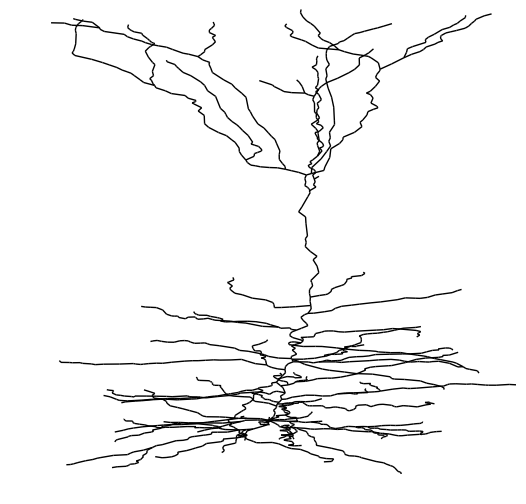

In [2]:
neuron_list = McNeuron.visualize.get_all_path(os.getcwd()+"/Data/Pyramidal/chen")
neuron = McNeuron.Neuron(file_format = 'swc', input_file=neuron_list[50])
McNeuron.visualize.plot_2D(neuron)

In [3]:
#tmp = neuron.subsample_main_nodes()
print np.shape(neuron.parent_index)
print neuron.parent_index[:10]

(1584,)
[0 0 0 0 3 4 5 6 7 8]


## Data parsing

In [4]:
from numpy import linalg as LA

def random_subsample(neuron, number_random_node):
    """
    randomly select a few number of nodes on the neuron and make a neuron based on that. 
    In the selected nodes, the consecutive nodes on the neuron connects by a stright line.
    Parameters
    ----------
    neuron: Neuron 
    number_random_node: int
        number of nodes to be selected.

    Returns
    -------
        The subsample neuron. 
    """
    I = np.arange(neuron.n_soma, neuron.n_node)
    np.random.shuffle(I)
    selected_index = I[0:number_random_node]
    selected_index = np.union1d(np.arange(neuron.n_soma), selected_index)
    selected_index = selected_index.astype(int)
    selected_index = np.unique(np.sort(selected_index))
    parent_ind = np.array([],dtype = int)
    for i in selected_index:
        p = neuron.parent_index[i]
        while(~np.any(selected_index == p)):
            p = neuron.parent_index[p]
        (ind,) = np.where(selected_index==p)
        parent_ind = np.append(parent_ind, ind)
    n_list = []
    for i in range(selected_index.shape[0]):
        n = McNeuron.Node()
        n.xyz = neuron.nodes_list[selected_index[i]].xyz
        n.r = neuron.nodes_list[selected_index[i]].r
        n.type = neuron.nodes_list[selected_index[i]].type
        n_list.append(n)

    for i in np.arange(1,selected_index.shape[0]):
        j = parent_ind[i]
        n_list[i].parent = n_list[j]
        n_list[j].add_child(n_list[i])
    return McNeuron.Neuron(file_format = 'only list of nodes', input_file = n_list)

def mesoscale_subsample(neuron, number):
    main_point = neuron.subsample_main_nodes()
    Nodes = main_point.nodes_list
    num_rm = (main_point.n_node - number)/2.
    for remove in range(int(num_rm)):
        pair_list = []
        Dis = np.array([])
        for n in Nodes:
            if n.parent is not None:
                if n.parent.parent is not None:
                    a = n.parent.children
                    if(len(a)==2):
                        n1 = a[0]
                        n2 = a[1]
                        if(len(n1.children) == 0 and len(n2.children) == 0):
                            pair_list.append([n1 , n2])
                            dis = LA.norm(a[0].xyz - a[1].xyz,2)
                            Dis = np.append(Dis,dis)
        (b,) = np.where(Dis == Dis.min())
        b = pair_list[b[0]]
        par = b[0].parent
        loc = b[0].xyz + b[1].xyz
        loc = loc/2
        par.children = []
        par.xyz = loc
        Nodes.remove(b[1])
        Nodes.remove(b[0])
        
    return McNeuron.Neuron(file_format = 'only list of nodes', input_file = Nodes)

def reducing_data(swc_df, pruning_number=10):
    """
    Parameters
    ----------
    swc_df: dataframe
        the original swc file
    pruning_number: int
        number of nodes remaining at the end of pruning
        
    Returns
    -------
    pruned_df: dataframe
        pruned dataframe
    
    """
    L = []
    for i in range(len(swc_df)):
        L.append(mesoscale_subsample(McNeuron.Neuron(file_format = 'swc', input_file = swc_df[i]), pruning_number))
    
    return L
    
def separate(list_of_neurons):
    """
    Parameters
    ----------
    list_of_neurons: List of Neurons
        
        
    Returns
    -------
    geometry: array of shape (n-1, 3)
        (x, y, z) coordinates of each shape assuming that soma is at (0, 0, 0)
        
    morphology : array of shape (n-1,)
        index of node - index of parent
    """
    Geo = list()
    Morph = list()
    for n in range(len(list_of_neurons)):
        neuron = list_of_neurons[n]
        Geo.append(neuron.location)
        Morph.append(neuron.parent_index)
    
    return Geo, Morph

### Test visualization and reducing data

Number of nodes: 10


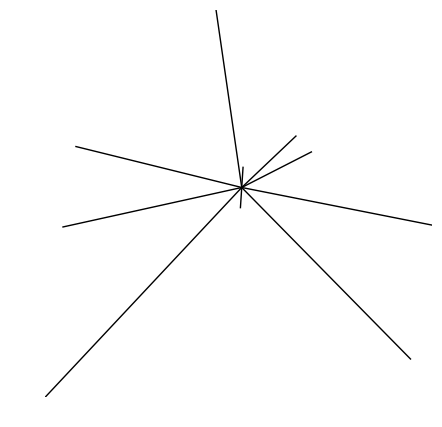

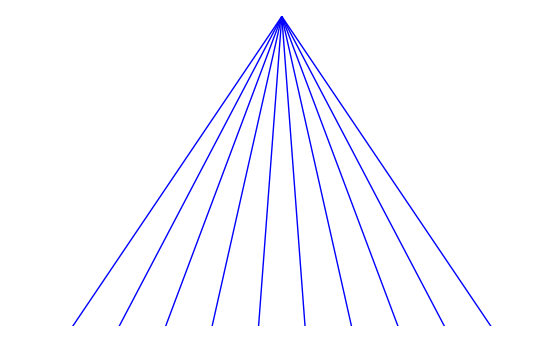

Number of nodes: 20


McNeuron/visualize.py:758: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  matrix[i,L[i]-1] = 1


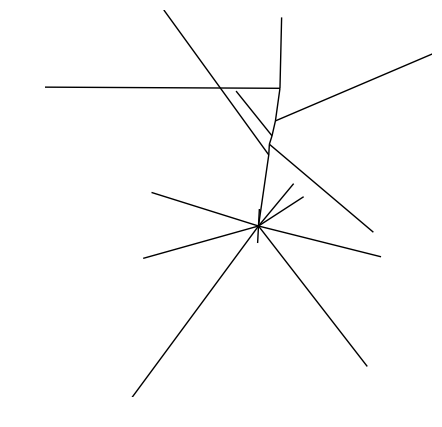

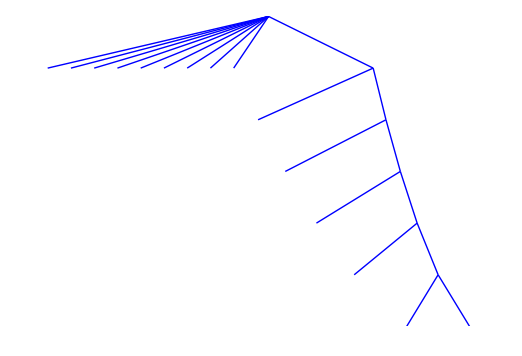

Number of nodes: 30


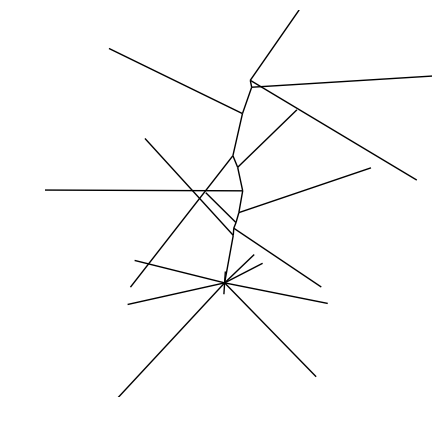

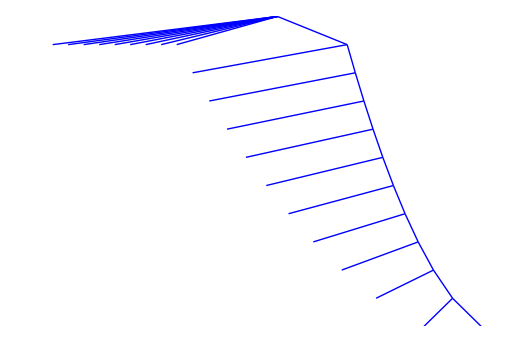

Number of nodes: 40


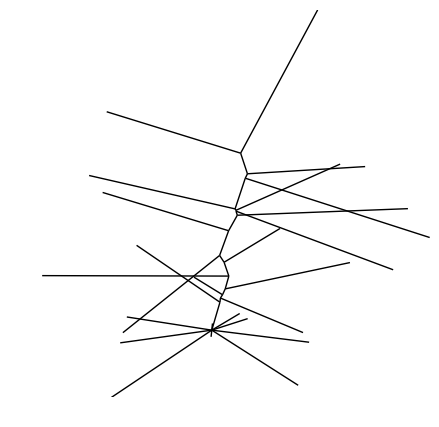

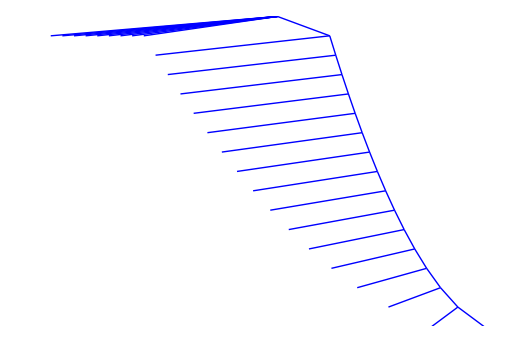

Number of nodes: 50


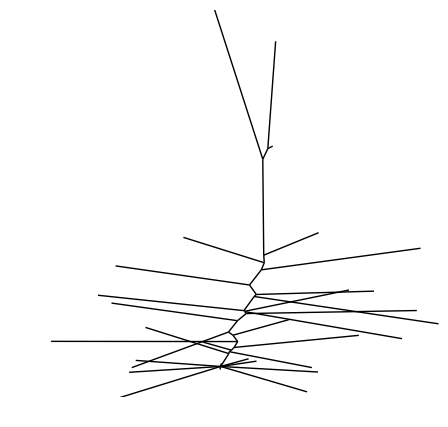

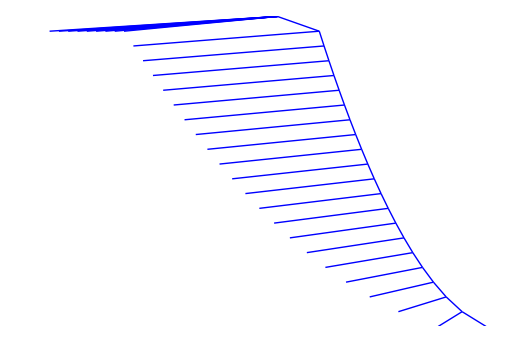

Number of nodes: 60


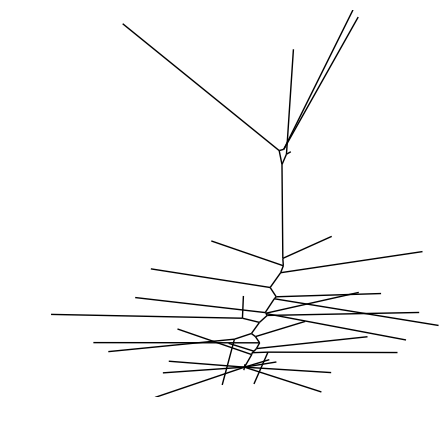

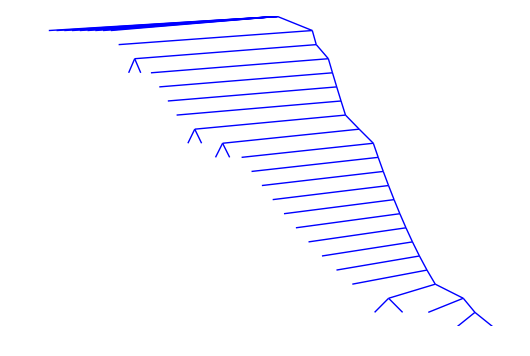

Number of nodes: 70


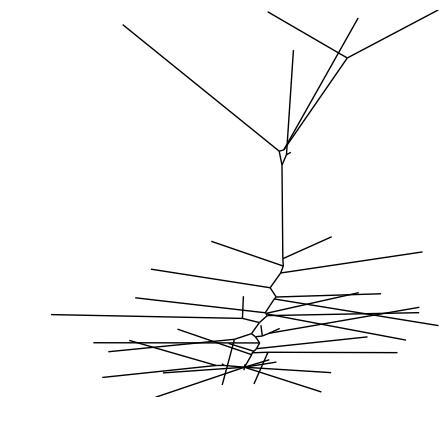

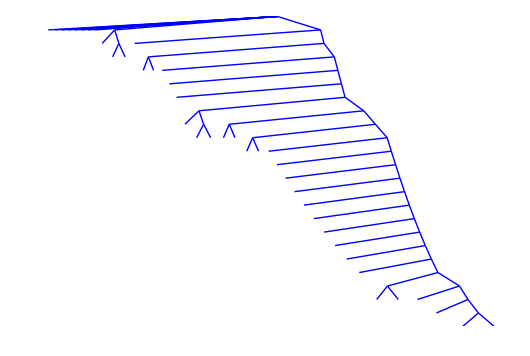

Number of nodes: 80


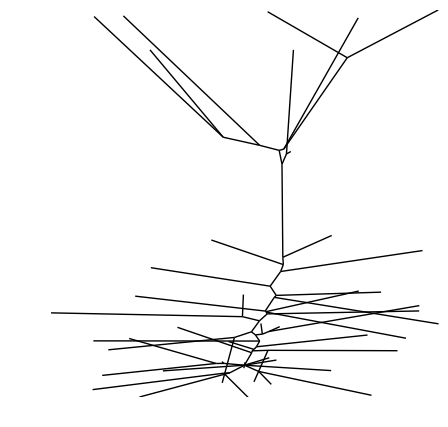

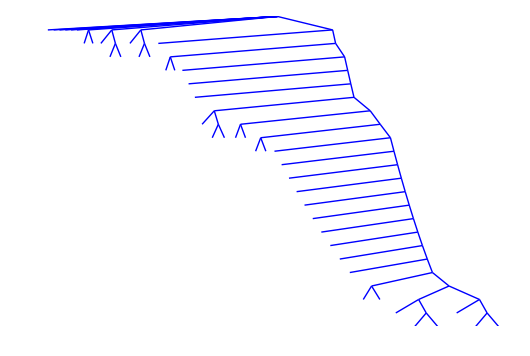

Number of nodes: 90


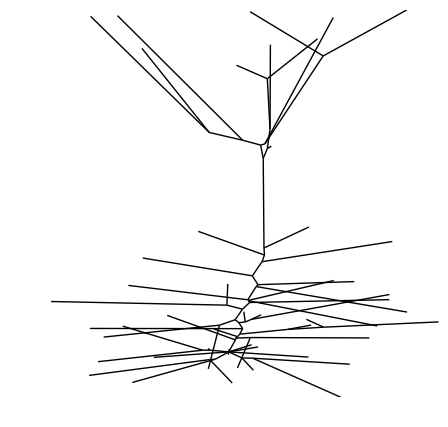

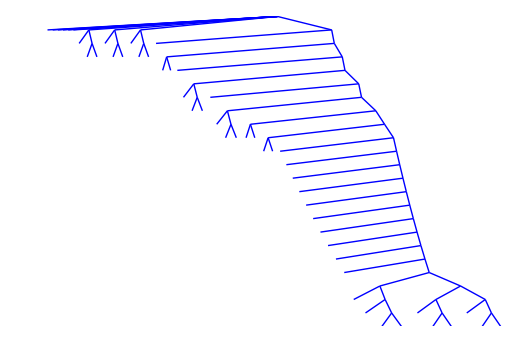

Number of nodes: 100


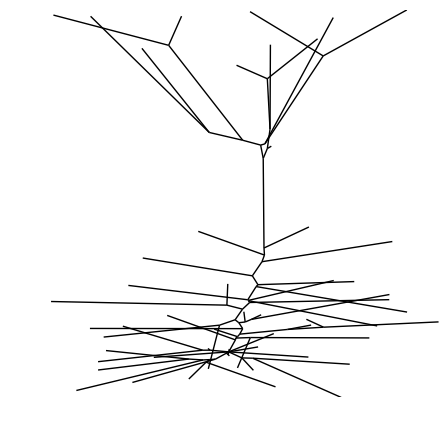

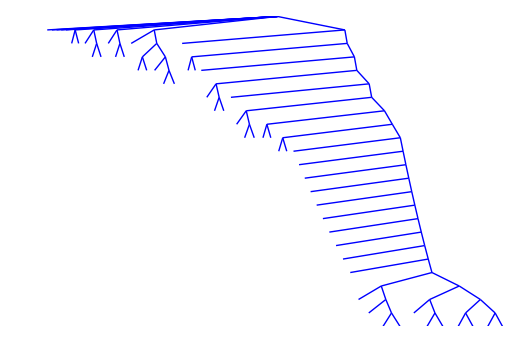

Number of nodes: 110


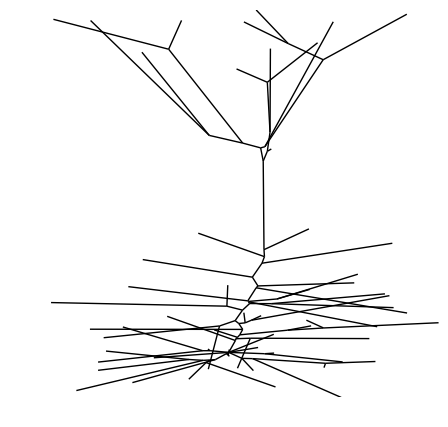

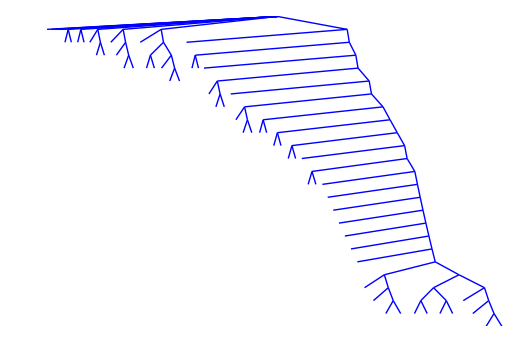

Number of nodes: 120


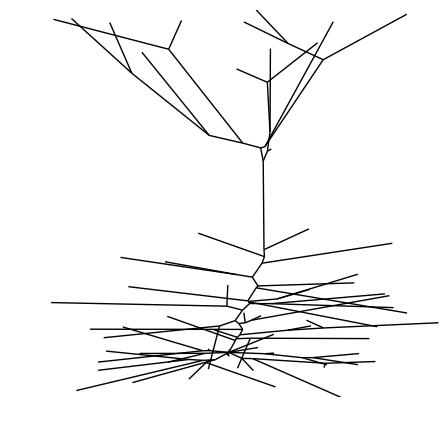

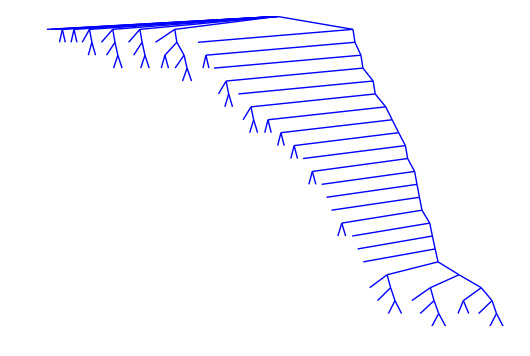

Number of nodes: 130


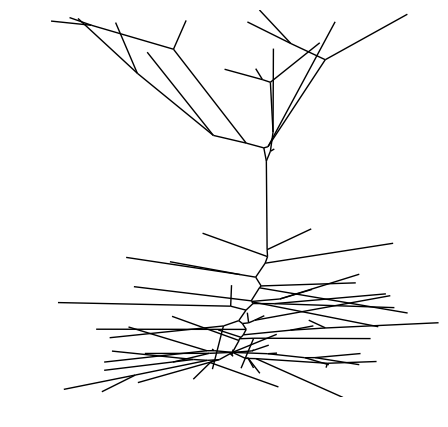

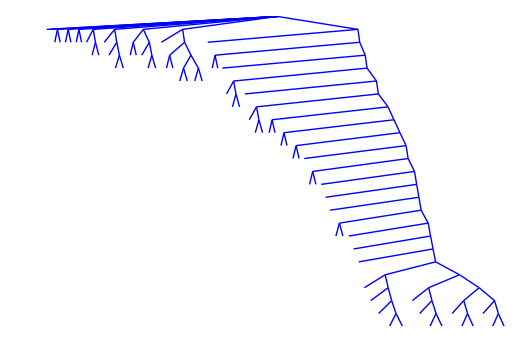

Number of nodes: 140


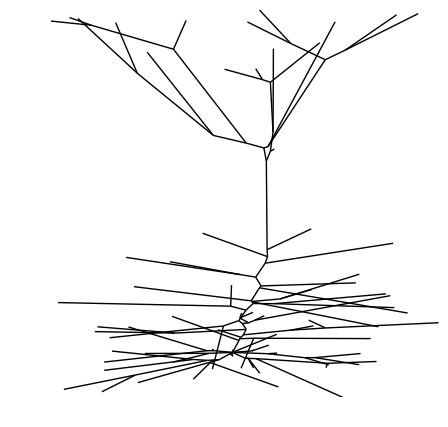

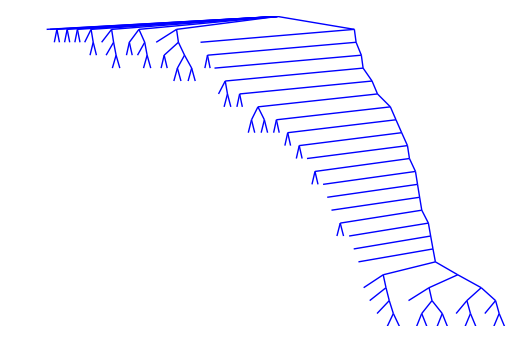

Number of nodes: 150


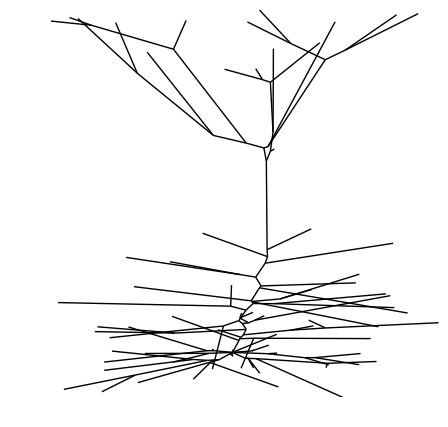

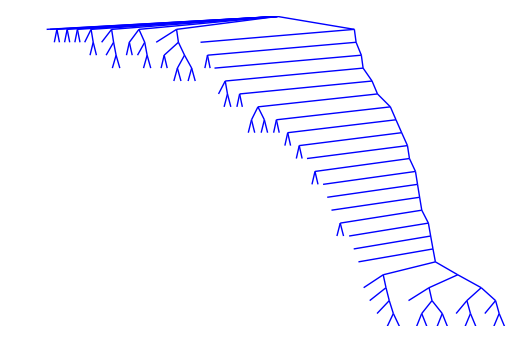

Number of nodes: 160


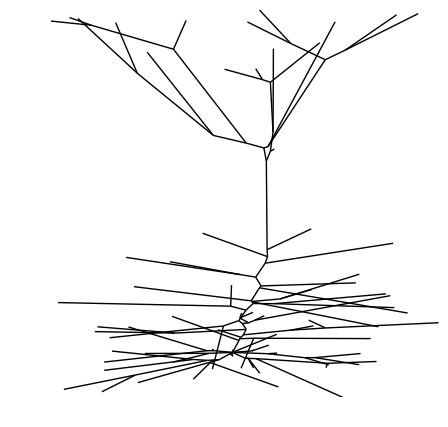

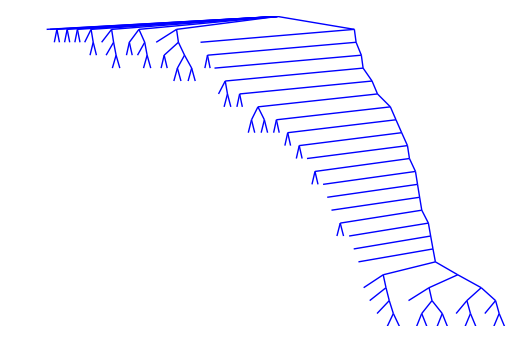

Number of nodes: 170


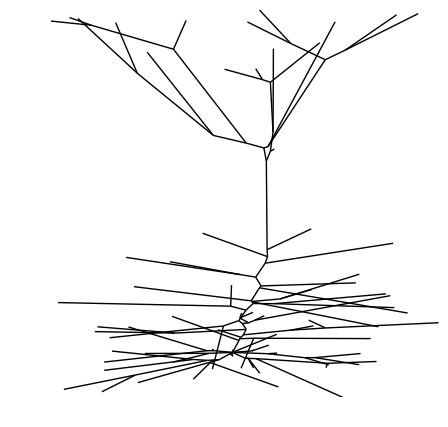

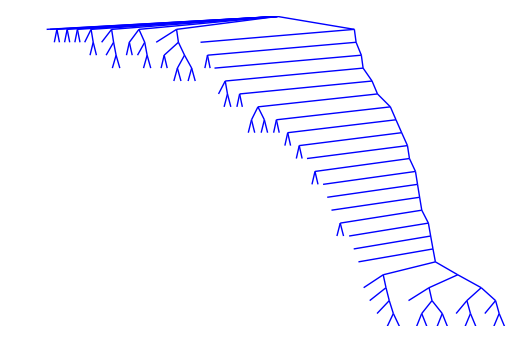

Number of nodes: 180


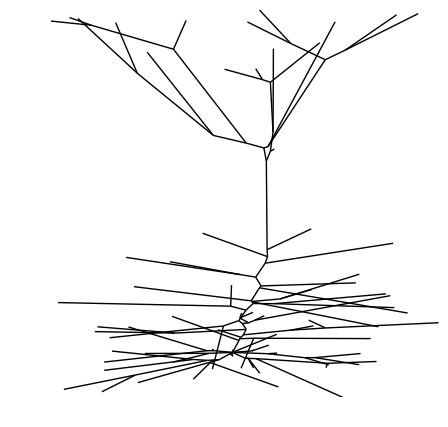

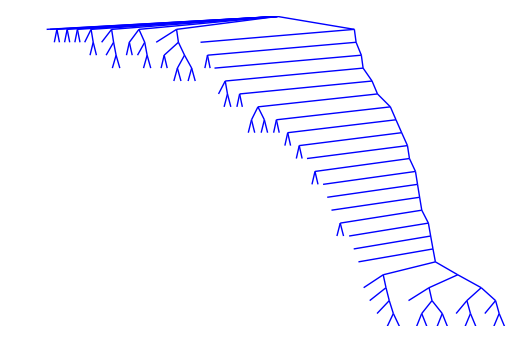

Number of nodes: 190


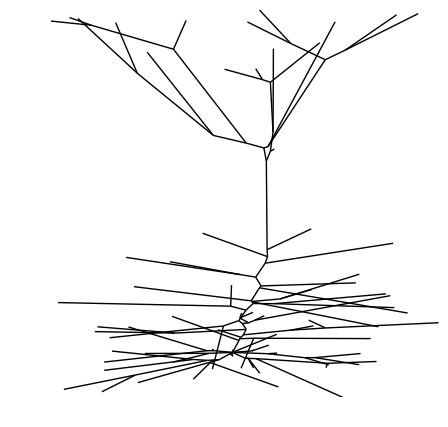

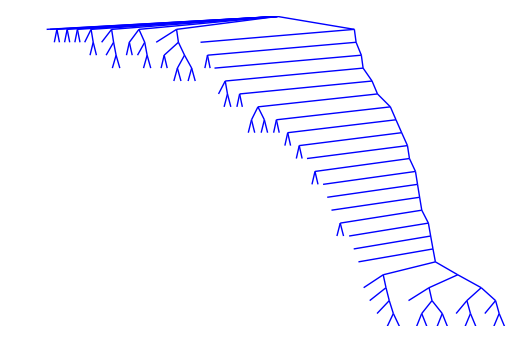

Number of nodes: 200


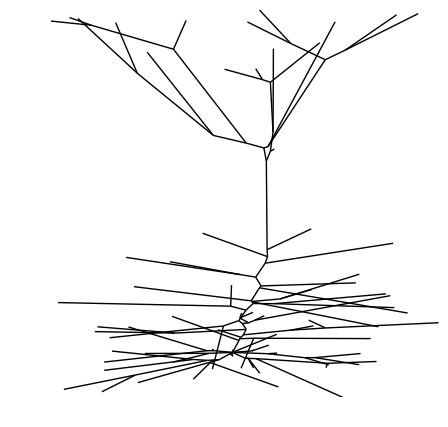

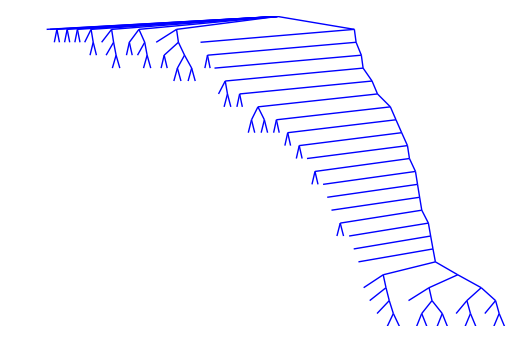

In [5]:
for i in range(20):
    n_nodes = 10 + 10 * i
    subsampled_neuron = mesoscale_subsample(deepcopy(neuron), n_nodes)
    print 'Number of nodes: %d' % (n_nodes)
    McNeuron.visualize.plot_2D(subsampled_neuron, size = 4)
    McNeuron.visualize.plot_dedrite_tree(subsampled_neuron)
    plt.show()

#### Testing function: reducing_data [works]

In [6]:
tmp = reducing_data(neuron_list[0:1], pruning_number=20)

#### Testing function: separate [works]

In [7]:
geo, morph = separate(tmp)

In [8]:
morph[0]

array([ 0,  0,  0,  0,  3,  3,  5,  5,  0,  0,  0, 10, 11, 12, 13, 14, 14,
       13, 12, 11, 10])

In [9]:
for nn in range(np.shape(geo)[-1]):
    print np.round(geo[0][0, nn]), np.round(geo[0][1, nn]), np.round(geo[0][2, nn])

0.0 0.0 0.0
0.0 7.0 0.0
-0.0 -7.0 0.0
-8.0 -14.0 3.0
-21.0 -121.0 -1.0
0.0 -31.0 -0.0
128.0 -88.0 -3.0
-44.0 -109.0 -7.0
31.0 -97.0 -7.0
-145.0 60.0 -1.0
2.0 26.0 -1.0
3.0 37.0 -0.0
5.0 39.0 -0.0
7.0 51.0 0.0
8.0 56.0 1.0
36.0 87.0 -3.0
30.0 64.0 2.0
14.0 43.0 4.0
78.0 39.0 -5.0
-57.0 104.0 -3.0
-42.0 17.0 -4.0


In [10]:
morph[0]

array([ 0,  0,  0,  0,  3,  3,  5,  5,  0,  0,  0, 10, 11, 12, 13, 14, 14,
       13, 12, 11, 10])

In [11]:
for nn in range(np.shape(geo)[-1]):
    print np.round(geo[0][0, nn]), np.round(geo[0][1, nn]), np.round(geo[0][2, nn])

0.0 0.0 0.0
0.0 7.0 0.0
-0.0 -7.0 0.0
-8.0 -14.0 3.0
-21.0 -121.0 -1.0
0.0 -31.0 -0.0
128.0 -88.0 -3.0
-44.0 -109.0 -7.0
31.0 -97.0 -7.0
-145.0 60.0 -1.0
2.0 26.0 -1.0
3.0 37.0 -0.0
5.0 39.0 -0.0
7.0 51.0 0.0
8.0 56.0 1.0
36.0 87.0 -3.0
30.0 64.0 2.0
14.0 43.0 4.0
78.0 39.0 -5.0
-57.0 104.0 -3.0
-42.0 17.0 -4.0


## Embedders

### Geometry

In [2]:
def geometry_embedder(n_nodes=10, embedding_dim=100):
    """
    Embedding of geometric coordinates of nodes.

    Parameters
    ----------
    n_nodes: int
        number of nodes
    embedding_dim: int
        embedding_dimension

    Returns
    -------
    geom_input: keras layer object
        input layer
    geom_embedded: keras layer object
        embedding layer
    """
    geom_input = Input(shape=(n_nodes - 1, 3))
    geom_reshaped = Reshape(target_shape=(1, (n_nodes - 1) * 3))(geom_input)
    geom_embedded = Dense(input_dim=(n_nodes - 1) * 3,
                          output_dim=embedding_dim,
                          name='geom_embed')(geom_reshaped)
    return geom_input, geom_embedded


### Morphology

In [3]:
def morphology_embedder(n_nodes=10, embedding_dim=100):
    """
    Embedding of tree morphology (softmax Prufer code).

    Parameters
    ----------
    n_nodes: int
        number of nodes
    embedding_dim: int
        embedding_dimension

    Returns
    -------
    morph_input: keras layer object
        input layer
    morph_embedded: keras layer object
        embedding layer
    """
    morph_input = Input(shape=(n_nodes - 2, n_nodes))
    morph_reshaped = \
        Reshape(target_shape=(1, (n_nodes - 2) * n_nodes))(morph_input)
    morph_embedded = Dense(input_dim=(n_nodes - 2) * n_nodes,
                           output_dim=embedding_dim,
                           name='morph_embed')(morph_reshaped)
    return morph_input, morph_embedded


## Generators

In [4]:
def generator(n_nodes_in=10,
              n_nodes_out=20,
              input_size=100,
              embedding_size=100,
              hidden_size=10,
              use_context=True):
    """
    Generator network.

    Parameters
    ----------
    n_nodes_in: int
        number of nodes in the neuron providing context input
    n_nodes_out: int
        number of nodes in the output neuron
    input_size: int
        dimensionality of noise input
    embedding_size: int
        dimensionality of embedding for context input
    use_context: bool
        if True, use context, else only noise input

    Returns
    -------
    geom_model: keras model object
        model of geometry generator
    morph_model: keras model object
        model of morphology generator
    """
    # Embed contextual information
    if use_context is True:
        geom_input, geom_embedded = \
            geometry_embedder(n_nodes=n_nodes_in,
                              embedding_dim=embedding_size)
        morph_input, morph_embedded = \
            morphology_embedder(n_nodes=n_nodes_in,
                                embedding_dim=embedding_size)

    # Generate noise input
    noise_input = Input(shape=(1, input_size), name='noise_input')

    # Concatenate context and noise inputs
    if use_context is True:
        all_inputs = merge([geom_embedded,
                            morph_embedded,
                            noise_input], mode='concat')
    else:
        all_inputs = noise_input

    # -------------------
    # Geometry model
    # -------------------
    # Synthesize output
    geom_output_size = (n_nodes_out - 1) * 3
    geom_hidden = Dense(geom_output_size)(all_inputs)

    # Reshape
    geom_output = Reshape(target_shape=(n_nodes_out - 1, 3))(geom_hidden)

    # Assign inputs and outputs of the model
    if use_context is True:
        geom_model = Model(input=[geom_input,
                                  morph_input,
                                  noise_input],
                           output=geom_output)
    else:
        geom_model = Model(input=noise_input, output=geom_output)

    # -------------------
    # Morphology model
    # -------------------
    # Synthesize output
    morph_hidden_size = hidden_size * (n_nodes_out - 2)
    morph_hidden = Dense(morph_hidden_size)(all_inputs)

    # Reshape
    morph_reshaped = \
        Reshape(target_shape=(n_nodes_out - 2, hidden_size))(morph_hidden)

    # LSTM
    morph_lstm = LSTM(input_dim=hidden_size,
                      input_length=n_nodes_out - 2,
                      output_dim=hidden_size,
                      return_sequences=True)(morph_reshaped)

    # TimeDistributed
    morph_output = TimeDistributed(Dense(input_dim=hidden_size,
                                         output_dim=n_nodes_out,
                                         activation='softmax'))(morph_lstm)

    # Assign inputs and outputs of the model
    if use_context is True:
        morph_model = \
            Model(input=[geom_input,
                         morph_input,
                         noise_input],
                  output=morph_output)
    else:
        morph_model = Model(input=noise_input,
                            output=morph_output)

    return geom_model, morph_model


### Testing generators [without context] [works]

In [8]:
input_size = 100
batch_size = 32
n_nodes = 10

geom_model, morph_model = generator(use_context=False, n_nodes_out=n_nodes)

random_code = np.random.randn(batch_size, 1, input_size)

locations = geom_model.predict(random_code)
print locations.shape

prufer_code = morph_model.predict(random_code)
print prufer_code.shape



(32, 9, 3)
(32, 8, 10)


### Testing generators [with context] [works]

In [9]:
geom_model_2, morph_model_2 = generator(use_context=True, n_nodes_in=10, n_nodes_out=20)
random_code_2 = np.random.randn(batch_size, 1, input_size)

locations_2 = geom_model_2.predict([locations, prufer_code, random_code_2])
print locations_2.shape

prufer_code_2 = morph_model_2.predict([locations, prufer_code, random_code_2])
print prufer_code_2.shape

(32, 19, 3)
(32, 18, 20)


## Discriminator

In [14]:
def discriminator(n_nodes_in=10,
                  embedding_size=100,
                  hidden_size=50):
    """
    Discriminator network.

    Parameters
    ----------
    n_nodes_in: int
        number of nodes in the neuron providing context input
    embedding_size: int
        dimensionality of embedding for context input
    hidden_size: int
        dimensionality of hidden layers

    Returns
    -------
    disc_model: keras model object
        model of discriminator
    """
    # Embed geometry
    geom_input, geom_embedded = \
        geometry_embedder(n_nodes=n_nodes_in,
                          embedding_dim=embedding_size)
    
    # Embed morphology
    morph_input, morph_embedded = \
        morphology_embedder(n_nodes=n_nodes_in,
                            embedding_dim=embedding_size)

    # Concatenate embeddings
    all_inputs = merge([geom_embedded, morph_embedded],
                       mode='concat')

    # --------------------
    # Discriminator model
    # -------------------=
    disc_hidden1 = Dense(hidden_size)(all_inputs)
    disc_hidden2 = Dense(hidden_size)(disc_hidden1)
    disc_output = Dense(1, activation='sigmoid')(disc_hidden2) 
    
    disc_model = \
            Model(input=[geom_input,
                         morph_input],
                  output=disc_output)

    return disc_model

### Testing discriminator [works]

In [73]:
disc_model = discriminator(n_nodes_in=10)
disc_labels = disc_model.predict([locations, prufer_code])
print disc_labels.shape
print np.squeeze(disc_labels)

(32, 1, 1)
[ 0.57906735  0.42075354  0.77581543  0.64417249  0.85809797  0.28334326
  0.31913471  0.41865829  0.64483404  0.45042154  0.25790834  0.67761713
  0.77742207  0.50195521  0.3112902   0.74706978  0.56492347  0.61909246
  0.84311783  0.9428423   0.59040588  0.66408533  0.34832606  0.70126134
  0.46504092  0.21535358  0.43739128  0.83624524  0.85142601  0.37034041
  0.39196897  0.44062951]


In [75]:
disc_model_2 = discriminator(n_nodes_in=20)
disc_labels = disc_model_2.predict([locations_2, prufer_code_2])
print disc_labels.shape
print np.squeeze(disc_labels)

(32, 1, 1)
[ 0.67102909  0.42372495  0.29345295  0.11068282  0.1597704   0.63290906
  0.69510502  0.39277038  0.85582912  0.45449328  0.04107584  0.6589973
  0.81429523  0.2151126   0.43608707  0.79502821  0.4463785   0.69211358
  0.4287996   0.62214845  0.54122502  0.77030921  0.22485471  0.68882656
  0.3790015   0.48647708  0.15412286  0.81328344  0.34935451  0.38780645
  0.38650087  0.66538721]


## Discriminator on generators

In [81]:
def discriminator_on_generators(geom_model,
                                morph_model,
                                disc_model,
                                input_size=100,
                                n_nodes_in=10,
                                use_context=True):
    """
    Discriminator stacked on the generators.

    Parameters
    ----------
    geom_model: keras model object
        model object that generates the geometry
    morph_model: keras model object
        model object that generates the morphology
    disc_model: keras model object
        model object for the discriminator
    n_nodes_in: int
        number of nodes in the neuron providing context input for the generators
    embedding_size: int
        dimensionality of embedding for context input
    hidden_size: int
        dimensionality of hidden layers
    use_context: bool
        if True, use context, else only noise input for the generators

    Returns
    -------
    model: keras model object
        model of the discriminator stacked on the generator
    """
    # Inputs
    if use_context is True:
        geom_input = Input(shape=(n_nodes_in - 1, 3))
        morph_input = Input(shape=(n_nodes_in - 2, n_nodes_in))
        
    noise_input = Input(shape=(1, input_size), name='noise_input')
    
    # Generator outputs
    if use_context is True:
        geom_output = geom_model([geom_input,
                                  morph_input,
                                  noise_input])    
        morph_output = morph_model([geom_input,
                                    morph_input,
                                    noise_input])
    else:
        geom_output = geom_model(noise_input)
        morph_output = morph_model(noise_input)
        
    # Freeze discriminator
    disc_model.trainable=False
    
    # Discriminator output
    disc_output = disc_model([geom_output,
                              morph_output])
    
    # Stack discriminator on generator
    if use_context is True:
        model = Model([geom_input,
                       morph_input,
                       noise_input],
                      disc_output)
    else:
        model = Model(noise_input,
                      disc_output)
    return model

### Testing discriminator on generators [works]

In [82]:
model = discriminator_on_generators(geom_model,
                                    morph_model,
                                    disc_model,
                                    input_size=100,
                                    n_nodes_in=10,
                                    use_context=False)
print model.input_shape, model.output_shape

(None, 1, 100) (None, 1, 1)


In [83]:
model = discriminator_on_generators(geom_model_2,
                                    morph_model_2,
                                    disc_model_2,
                                    input_size=100,
                                    n_nodes_in=10,
                                    use_context=True)
print model.input_shape, model.output_shape

[(None, 9, 3), (None, 8, 10), (None, 1, 100)] (None, 1, 1)


## Prufer codes for trees

It is useful to represent the tree structure as a Prufer code. See [1, 2].

Advantage:
- We can restrict the "vocabulary" to $n-2$ for a tree of $n$ nodes.
- Any arbitrary sequence of $n-2$ integers from this vocabulary is a legitimate tree.
- Thus, our GAN only has to learn the statistics of our neuronal trees. Crucially, it doesn't have to waste time learning trees from non-trees.

[1] https://en.wikipedia.org/wiki/Pr%C3%BCfer_sequence

[2] http://www-math.ucdenver.edu/~wcherowi/courses/m4408/gtaln7.html


In [18]:
def get_leaves(nodes, parents):
    return np.sort(list(set(nodes) - set(parents)))

def encode_prufer(parents, verbose=0):
    """
    Convert the parents sequence to a prufer sequence
    """
    n_nodes = len(parents)
    nodes = range(n_nodes)
    
    prufer = list()
    for n in range(n_nodes - 2):
        
        # Recalculate all the leaves
        leaves = get_leaves(nodes, parents)
        if verbose:
            print 'leaves', leaves
        
        # Add the parent of the lowest numbered leaf to the sequence
        leaf_idx = np.where(nodes == leaves[0])[0][0]
        prufer.append(parents[leaf_idx])
        if verbose: 
            print 'prufer', prufer
        
        # Remove the lowest numbered leaf and its corresponding parent
        del nodes[leaf_idx]
        del parents[leaf_idx]
        
        if verbose:
            print 'nodes', nodes
            print 'parents', parents
            print 60*'-'
            
    return prufer

def decode_prufer(prufer, verbose=0):
    """
    Convert the prufer sequence to a parents sequence
    """
    n_nodes = len(prufer) + 2
    n_prufer = len(prufer)
    nodes = range(n_nodes)
    parents = -1 * np.ones(n_nodes)
    
    for n in range(n_prufer):
        if verbose:
            print nodes
            print prufer
        leaves = list(get_leaves(nodes, prufer))
        k = leaves[0]
        j = prufer[0]

        if k==0:
            k = leaves[1]
            
        if verbose:
            print k, j
        parents[k] = j
        
        leaf_idx = np.where(nodes == k)[0][0]
        del nodes[leaf_idx]
        del prufer[0]
        
        if verbose:
            print 60*'-'
        
    parents[nodes[1]] = nodes[0]
    return list(parents.astype(int))

In [19]:
for j in range(prufer_code.shape[0]):
    parents_code = decode_prufer(list(prufer_code[j].argmax(axis=1)))
    print prufer_code[j].argmax(axis=1), parents_code

[1 1 1 1 7 9 9 9] [-1, 7, 1, 1, 1, 1, 9, 9, 9, 0]
[1 8 8 6 1 0 1 0] [-1, 0, 1, 8, 8, 6, 1, 0, 1, 0]
[5 6 6 6 7 7 1 0] [-1, 0, 5, 6, 6, 6, 7, 1, 7, 0]
[4 4 0 6 1 9 9 9] [-1, 9, 4, 4, 0, 6, 1, 9, 9, 0]
[1 1 6 6 8 8 1 1] [-1, 0, 1, 1, 6, 6, 8, 8, 1, 1]
[4 4 9 9 3 6 6 6] [-1, 4, 4, 6, 9, 9, 0, 3, 6, 6]
[5 6 9 2 9 9 9 9] [-1, 5, 9, 6, 9, 2, 9, 9, 9, 0]
[1 1 1 9 9 3 6 6] [-1, 9, 1, 6, 1, 1, 0, 9, 3, 6]
[6 8 1 1 6 1 0 0] [-1, 0, 6, 8, 1, 1, 1, 6, 0, 0]
[4 5 5 1 6 6 3 2] [-1, 6, 0, 2, 5, 1, 3, 4, 5, 6]
[9 3 3 6 6 1 1 9] [-1, 9, 9, 6, 3, 3, 1, 6, 1, 0]
[3 3 6 9 9 9 1 9] [-1, 9, 3, 6, 3, 9, 9, 9, 1, 0]
[9 6 2 9 0 6 0 0] [-1, 9, 9, 6, 2, 0, 0, 6, 0, 0]
[9 1 0 6 0 0 6 1] [-1, 0, 9, 1, 0, 6, 1, 0, 0, 6]
[5 3 6 5 0 5 6 3] [-1, 5, 3, 0, 6, 6, 3, 5, 0, 5]
[2 5 5 2 2 2 1 8] [-1, 8, 1, 2, 5, 2, 5, 2, 0, 2]
[9 9 0 6 6 5 6 6] [-1, 9, 9, 0, 6, 6, 0, 6, 5, 6]
[9 3 2 3 3 2 3 2] [-1, 9, 0, 2, 3, 2, 3, 3, 2, 3]
[9 9 3 3 4 1 9 5] [-1, 9, 9, 4, 1, 0, 9, 3, 3, 5]
[9 1 8 6 0 9 0 0] [-1, 8, 9, 1, 6, 0, 9, 0, 0, 0]


In [22]:
for j in range(prufer_code_2.shape[0]):
    parents_code = decode_prufer(list(prufer_code_2[j].argmax(axis=1)))
    print prufer_code_2[j].argmax(axis=1), parents_code

[12  9 12 12 12  9 13 17  4  4  4  6 10 11 16  5  2  5] [-1, 12, 5, 9, 6, 0, 10, 12, 12, 13, 11, 16, 9, 17, 12, 4, 5, 4, 4, 2]
[12  2 16 11 16  0  0 14  7 13 13 13 10 10  9  0 10 10] [-1, 12, 16, 2, 11, 16, 0, 13, 0, 0, 0, 14, 7, 10, 13, 13, 10, 9, 10, 10]
[13  0  0  2  3  0  6 18 11  5  5  2  5  5  5  5 11  2] [-1, 13, 0, 0, 0, 11, 18, 0, 2, 3, 6, 2, 11, 5, 5, 2, 5, 5, 5, 5]
[ 7  1  1  8  7  5  1  5 12 12 12 12 12 12 12  0  0 10] [-1, 5, 7, 1, 1, 12, 8, 5, 7, 1, 0, 12, 0, 12, 12, 12, 12, 12, 0, 10]
[16  2  2  2  8  2  2  8  8  8 13 13  8 18 18 19  1  1] [-1, 0, 8, 16, 2, 2, 2, 8, 18, 2, 2, 8, 8, 8, 13, 13, 18, 19, 1, 1]
[10  8  8 15  8  2 15  8  8  2  2 17 15 15  5  5 19  7] [-1, 10, 17, 8, 8, 19, 15, 0, 2, 8, 2, 15, 8, 8, 2, 5, 15, 15, 5, 7]
[ 2  2  2 17  7 11 13  8  8 13 13 13 13 10 17 17 17  8] [-1, 2, 17, 2, 2, 7, 11, 13, 0, 8, 17, 8, 13, 10, 13, 13, 13, 8, 17, 17]
[ 2 19 16 16 12 12  5 10  0  0  0  0  4  7  0  1  1  1] [-1, 0, 19, 2, 7, 10, 16, 0, 16, 12, 0, 12, 5, 0, 0, 0, 4, 1,

In [51]:
def check_tree_code(tree_list):
    is_tree = np.zeros(tree_list.shape[0])
    for j in range(tree_list.shape[0]):
        tree = tree_list[j].argmax(axis=1)
        # parent should exist
        is_tree[j] = np.all(range(1, len(tree) + 1) - tree >= 1)
    return is_tree

### Model design:
- ~~Write down an encoder and decoder for the Prufer coded tree~~
- ~~Write down the architecture of the discriminator that combines morphology and geometry~~
- ~~How to design the hierarchy effectively?~~
- ~~How to condition generators on each other?~~

- Should we encode geometry as [r, theta, phi]? Reason: as we generate nodes farther from the tree, r increases. Using an LSTM instead of a Dense network could be useful for this representation.

- LSTM embedding for geometry instead of Dense?

### Code:
- ~~Generators~~
- ~~Discriminator~~
- Wasserstein loss for discriminator/critic
    - ~~write custom loss function in keras~~
    - figure out how to clip weights in keras
- Parse swc files into training data (~50k neurons)
- Prufer coder --> one-hot encoder for training examples
- Training one level
- Training multiple levels



